Importación de librerías y elementos necesarios

In [1]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
import skimage

Se lee el archivo de etiquetas. La clase 0 son las radiografías sin ninguna patología presente y la clase 1 son aquellas que presentan alguna patología.

In [2]:
labels_df = pd.read_csv("res_pre2/res_labels.csv" , nrows = 490)
labels_df.set_index("Image Index", inplace = True)
exampleLabels_df = labels_df.drop(columns=[col for col in labels_df.columns if col != "Finding Labels"])
labels_df = labels_df.drop(columns=[col for col in labels_df.columns if col != "Finding Labels"])
labels_df.loc[labels_df['Finding Labels'] == 'No Finding'] = 0
labels_df.loc[labels_df['Finding Labels'] != 0] = 1

Observemos la distribución entre las dos clases:

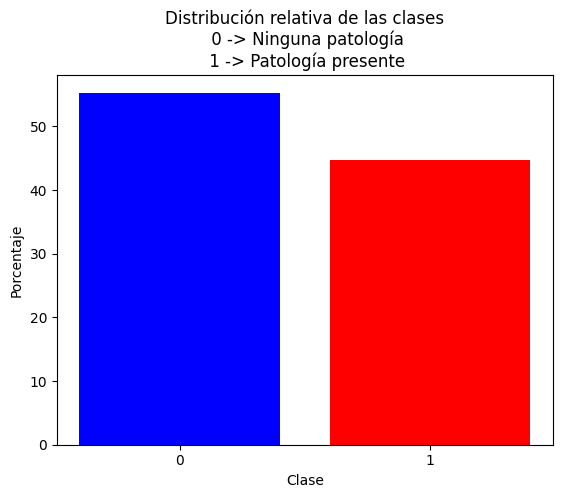

In [3]:
class_counts = labels_df['Finding Labels'].value_counts(normalize=True) * 100

# Plot the percentage distribution
colors = ['blue', 'red']
plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xlabel('Clase')
plt.ylabel('Porcentaje')
plt.title('Distribución relativa de las clases\n 0 -> Ninguna patología\n 1 -> Patología presente')
plt.xticks(class_counts.index)
plt.show()

Se puede concluir que existe una distribución equitativa entre los datos a utilizar para entrenar el modelo. 

Se cuenta con una frecuencia más alta de radiografías sin ninguna patología presente, lo que favorecerá el entrenamiento de un modelo conservador.

A continuación, se leen las imágenes:

In [4]:
#Creamos la función que leerá las imágenes
def img_read(filename, mode = 'color'):
    if(mode == 'color'):   
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    elif(mode=='yuv' or mode=='YUV'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2YUV)
    elif(mode=='hsv' or mode=='HSV'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2HSV)
    elif(mode=='lab' or mode=='LAB'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2LAB)
    
    elif(mode=='negativo' or mode=='negative'):
        return cv2.subtract(255 , cv2.imread(filename, cv2.IMREAD_GRAYSCALE))
    
    else:
        return None

In [5]:
# Define the path to the folder containing the images
image_folder_path = "res_pre2"

# List to store the loaded images
loaded_images = []
neg_loaded_images = []
labeled_images = []

# Iterate over the files in the folder
for filename in os.listdir(image_folder_path):
    if filename.endswith(".png"):
        # Construct the full file path
        image_path = os.path.join(image_folder_path, filename)

        # Load the image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = img_read(image_path, 'grayscale')
        

        image_neg = img_read(image_path, 'negativo')
        
        # Get the image label
        label = labels_df.loc[os.path.basename(image_path), "Finding Labels"]

        # Append the image to the list
        loaded_images.append(image)
        neg_loaded_images.append(image_neg)
        labeled_images.append([label, image])


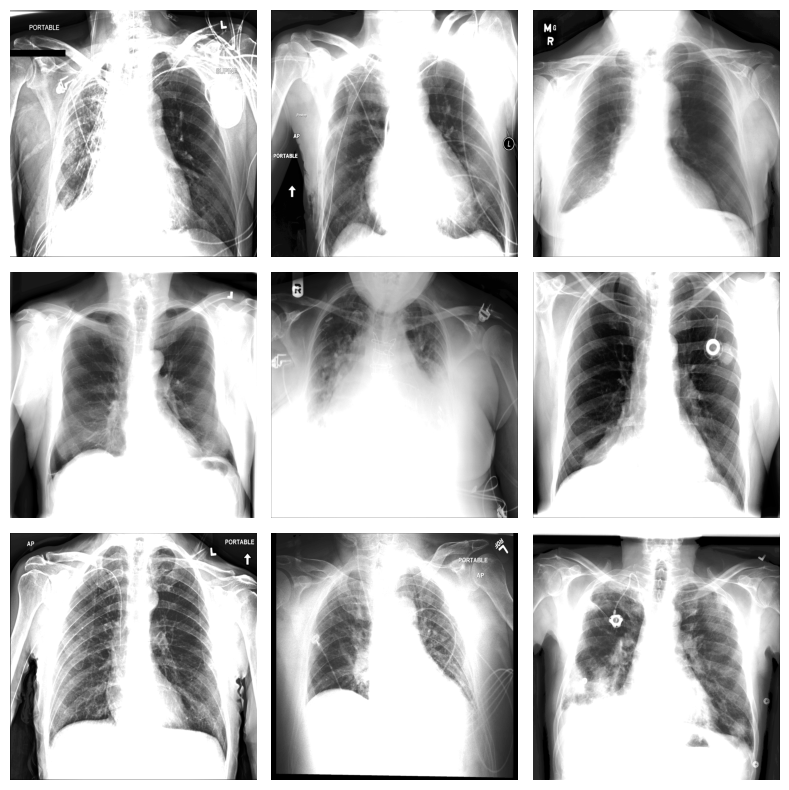

In [6]:
# Display a sample of 9 grayscale images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    # Check if there are still images to display
    if i < len(loaded_images):
        # Display the grayscale image
        ax.imshow(loaded_images[i], cmap='gray')
        ax.axis("off")

plt.tight_layout()
plt.show()

Visualizamos en negativo las muestras

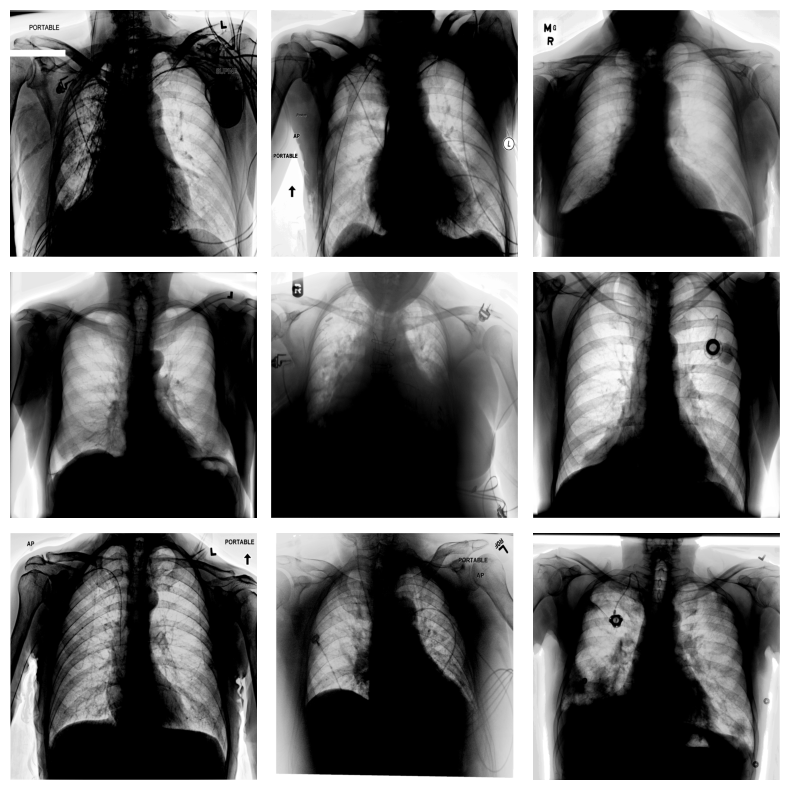

In [7]:


# Display a sample of 9 NEGATIVE grayscale images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    # Check if there are still images to display
    if i < len(loaded_images):
        # Display the grayscale image
        ax.imshow(neg_loaded_images[i], cmap='gray')
        ax.axis("off")

plt.tight_layout()
plt.show()

Definimos las funciones para transformar las imagenes antes de realizar detección de bordes Entre estas, hemos visto buenos resultados al ecualizar y al usar la corrección gamma

In [8]:
#Definir la función de transformación de la imagen (corrección gamma)
def gamma_correction(img, a, gamma):

    """
    Corrección gamma

    f(x) = a(x)^(gamma)
    
    img: imagen de entrada
    a: parametro a
    gamma: exponente gamma    
    """
        
    #Crear copia de la imagen tipo flotante dada la normalización
    img_copy = img.copy().astype(np.float32)/255.0
    
    #La función corrección gamma es de la forma ax^gamma donde x es la imagen de entrada
    res_gamma = cv2.pow(img_copy, gamma)
    res = cv2.multiply(res_gamma, a)
    
    #Asegurar que la los datos queden entre 0 y 255 y sean uint8
    res[res<0] = 0
    res = res*255.0
    res[res>255] = 255
    
    res = res.astype(np.uint8)
    return res





def apply_f_on_rgb(img, f, args):
    
    #Crear una matriz de ceros del tamaño de la imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Aplicar la transformación f sobre cada canal del espacio de color RGB
    res[:,:,0] = f(img[:,:,0], *args)
    res[:,:,1] = f(img[:,:,1], *args)
    res[:,:,2] = f(img[:,:,2], *args)
    
    return res

def histogram_equalization(img):
     
    #Crear matriz de ceros del tamaño de la imagen y tipo de dato flotante
    res = np.zeros(img.shape, np.float32)
    #Crear un vector 1-D de la matriz de la imagen, es decir "aplanarla"
    img_raveled = img.ravel()
    #Generar el histograma normalizado de la imagen 
    hist_norm = plt.hist(img_raveled, bins=255, range=(0.0, 255.0), density=True)
    #Limpiar la figura actual
    plt.clf()
    #hist_norm[0] es un vector de probabilidades. Añadir al vector, el valor [1 - sumatoria de sus datos]
    pdf = hist_norm[0]
    np.append(pdf, 1.0 - np.sum(pdf))
    #Dado que se añade un dato, se realiza la sumatoria de valores sobre todo el vector
    cdf = [np.sum(pdf[0:x]) for x in range(0,256)]
    #Hallar el valor mínimo y máximo de la imagen
    gmin = np.min(img)
    gmax = np.max(img)
    
    #Generar F(g) - Función de ecualización
    for g in range(0,256):
        res[img == g] = (gmax - gmin)*cdf[g] + gmin
    #Asegurar que los datos sean uint8 y esten en el rango correspondiente
    res[res<0] = 0
    res[res>255] = 255
    res = res.astype(np.uint8)
    return res

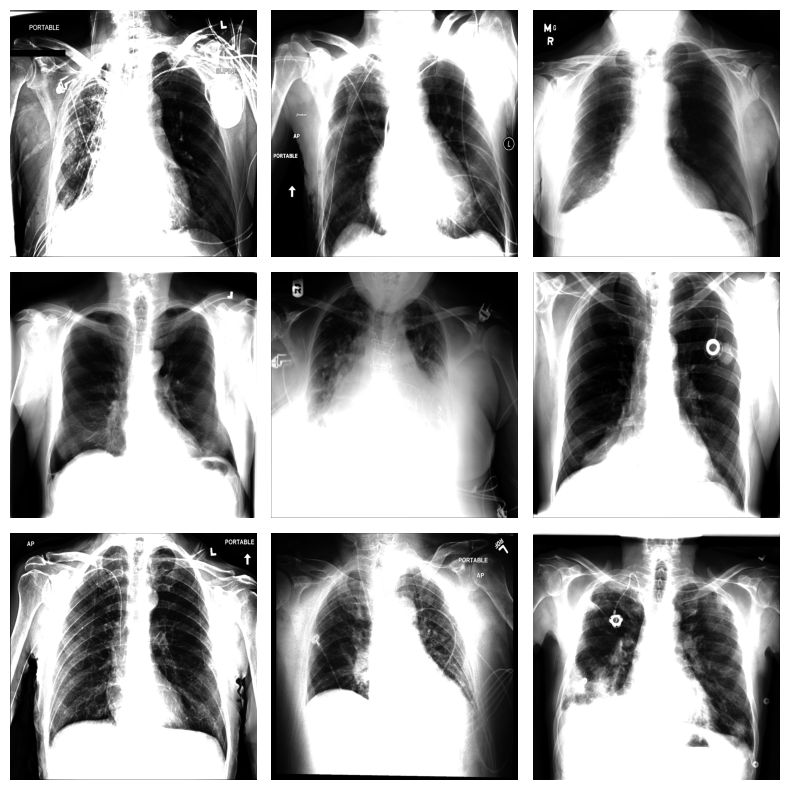

In [9]:
# Display a sample of 9 grayscale images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    # Check if there are still images to display
    if i < len(loaded_images):
        # Display the grayscale image
        ax.imshow(gamma_correction(loaded_images[i],a=0.9,gamma=2), cmap='gray')
        ax.axis("off")

plt.tight_layout()
plt.show()

Ahora, concatenamos cada imagen con su respectiva clasificación.

In [10]:
len(labeled_images)

490

In [11]:
# Create a DataFrame from the list
data_df = pd.DataFrame(labeled_images, columns=['Label', 'Image'])

# Print the DataFrame
data_df

,Label,Image
0,1,"[[163, 163, 163, 160, 160, 160, 157, 157, 160,..."
1,1,"[[2, 2, 2, 2, 2, 15, 15, 15, 15, 15, 15, 15, 1..."
2,0,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
3,1,"[[114, 94, 78, 62, 50, 42, 38, 36, 33, 31, 29,..."
4,1,"[[2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2,..."
...,...,...
485,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
486,1,"[[0, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
487,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
488,0,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."


In [12]:
# Separate the features (X) and the target variable (y)
X = data_df['Image']
y = data_df['Label']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train2, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Definimos los transformadores

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Preprocesamos

In [14]:
# create an instance of each transformer
# grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
# X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train2)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(392, 186624)


Entrenamos el modelo SGD (Stochastic Gradient Descent)

In [15]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

Probando el clasificador...

In [16]:
# X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_train2)
X_test_prepared = scalify.transform(X_test_hog)
y_pred = sgd_clf.predict(X_test_prepared)


In [18]:
#Muestra el porcentaje de exactitud
print('Percentage correct: ', 100*np.sum(y_pred[:len(y_test)] == y_test)/len(y_test))

Percentage correct:  48.97959183673469
